In [2]:
# 기본 import 패키지
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
%matplotlib inline

### 커널 서포트 벡터 머신
커널 서포트 벡터 머신*kernelized support vector machines*은 선형 서포트 벡터 머신을 입력 데이터에서 단순한 초평면으로 정의되지 않는 더 복잡한 모델을 만들 수 있도록 확장한 것이다.

#### 선형 모델과 비선형 특성
직선과 초평면은 유연하지 못하여 저차원 데이터셋에서는 선형 모델이 매우 제한적이다. 선형 모델을 유연하게 만드는 방법중  하나는 특성끼리 곱하거나 거듭제곱하는 식으로 새로운 특성을 추가하는 것이다.

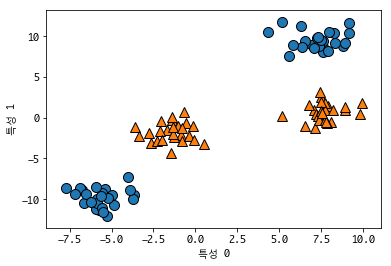

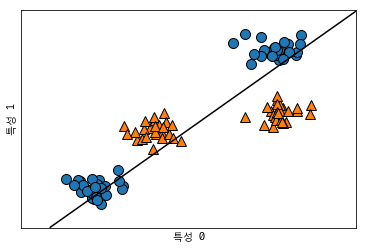

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

plt.show()

from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

선형 모델은 직선으로만 데이터를 나눌 수 있어 이런 데이터셋에는 잘 맞지 않는다.

두번째 특성을 제곱한 ${특성1}^2$을 새로운 특성으로 추가해 3차원 데이터 포인트로 표현한다.

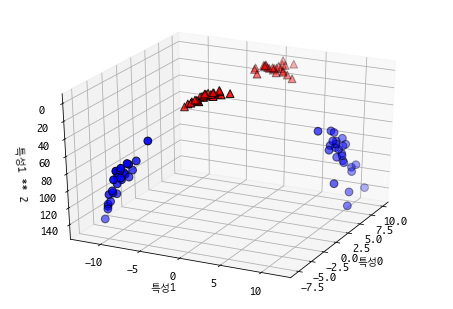

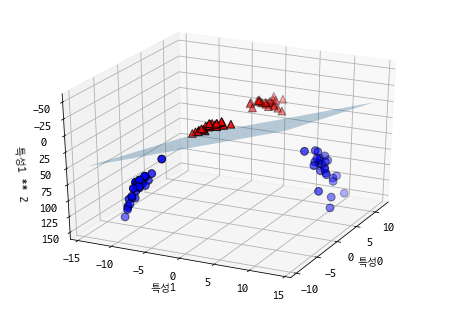

In [4]:
# 두 번째 특성을 제곱하여 추가합니다
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# 3차원 그래프
ax = Axes3D(figure, elev=-152, azim=-26)
# y == 0 인 포인트를 먼저 그리고 그 다음 y == 1 인 포인트를 그립니다
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel("특성0")
ax.set_ylabel("특성1")
ax.set_zlabel("특성1 ** 2")

linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# 선형 결정 경계 그리기
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("특성0")
ax.set_ylabel("특성1")
ax.set_zlabel("특성1 ** 2")

새로운 데이터셋에서는 평면을 사용해 두 클래스를 구분할 수 있다. 원래 특성으로 투영해보면 이 선형 SVM 모델은 선형이 아니라 타원에 가까운 모습이 된다.

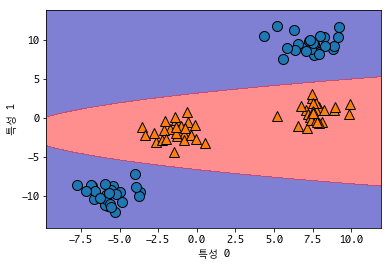

In [5]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

#### 커널 기법
비선형 특성을 추가하면 선형 모델이 강력해지지만 어떤 특성을 추가해야될지 모르고 많은 특성을 추가하면 연산 비용이 커진다. **커널 기법** *kernel trick*을 사용해 실제로 데이터를 확장하지 않고 확장된 특성에 대한 데이터 포인트들의 거리(스칼라 곱을 계산할 수 있다.

서포트 벡터 머신에서 데이터를 고차원 공간에 매핑하는데 많이 사용하는 방법은 두 가지이다.  
* 다항식 커널: 특성의 가능한 조합을 지정된 차수까지 모든 계산
* RBF*radial basis function* 커널: 가우시안*Gaussian* 커널이라고도 불린다. 차원이 무한한 특성 공간에 매핑한다. 모든 차수의 모든 다항식을 고려하는 것으로 이해하면 좋다. 지수 함수의 테일러 전개 때문에 특성의 중요도는 고차항이 될수록 줄어든다.

#### SVM 이해하기
SVM은 각 각 훈련 데이터 포인트가 클래스의 결정 경계를 구분하는데 얼마나 중요한지를 배운다. 일반적으로 결정 경계를 만드는데는 경계에 위치한 일부 훈련 데이터만 영향을 준다. 이런 데이터 포인트를 **서포트 벡터**라고 한다.

새로운 데이터에 대해 예측하려면 각 서포트 벡터와의 거리를 측정한다. 데이터 포인트 사이의 거리는 가우시안 커널에 의해 계산된다.
$$ k_{rbf} (x_1, x_2) = \exp(-\gamma \lVert x_1 - x_2 \rVert^2) $$
$x_1, x_2$: 데이터 포인트, $\lVert x_1 - x_2 \rVert$: 유클리드 거리, $\gamma$: 가우시안 커널의 폭을 제어하는 매개변수 

아래는 두 개의 클래스를 가진 2차원 forge 데이터셋의 SVM학습 결과이다. 결정 경계는 검은 실선, 서포트 벡터는 굵은 테두리로 처리했다. SVM은 매우 부드럽고 비선형인 경계를 만들었다.

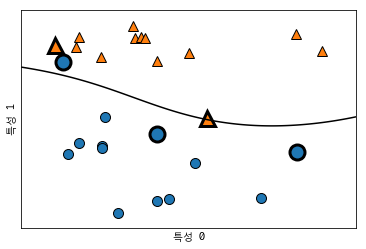

In [6]:
from sklearn.svm import SVC

X, y = mglearn.tools.make_handcrafted_dataset()                                                                  
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)                                                
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
# 데이터 포인트 그리기
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# 서포트 벡터
sv = svm.support_vectors_
# dual_coef_ 의 부호에 의해 서포트 벡터의 클래스 레이블이 결정됩니다
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

#### SVM 매개변수 튜닝
* gamma: 가우시안 커널 폭의 역수에 해당. 하나의 훈련 샘플이 미치는 영향의 범위를 결정한다. 클수록 영향을 미치는 범위가 적어진다.
* C: 선형 모델의 규제 매개변수에 해당. 각 포인트의 중요도(`duel_coef_`값)을 제한.

각 매개변수를 다르게 했을 때 어떻게 변경되는지 확인하자.

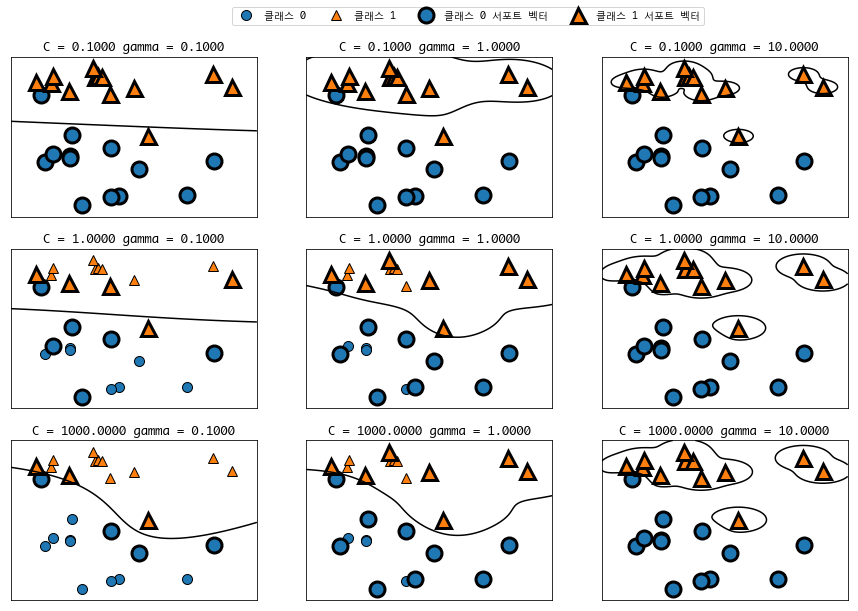

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["클래스 0", "클래스 1", "클래스 0 서포트 벡터", "클래스 1 서포트 벡터"],
                  ncol=4, loc=(.9, 1.2))

감마값이 커질수록 경계가 개별 포인트에 민감해져 복잡한 모델을 만든다.

작은 C값은 제약이 큰 모델을 만들며 각 데이터 포인트의 영향력이 작다.

RBF 커널 SVM을 유방암 데이터셋에 적용한다.(기본값 C=1, gamma=1/n_features)

훈련 세트 정확도: 1.00
테스트 세트 정확도: 0.63


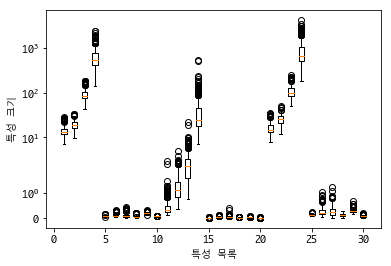

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print("훈련 세트 정확도: {:.2f}".format(svc.score(X_train, y_train)))
print("테스트 세트 정확도: {:.2f}".format(svc.score(X_test, y_test)))

plt.boxplot(X_train, manage_xticks=False)
plt.yscale("symlog")
plt.xlabel("특성 목록")
plt.ylabel("특성 크기")

훈련 세트는 100%지만 테스트 세트는 63%이기 때문에 상당히 과적합되었다. SVM은 매개변수 설정과 데이터 스케일에 매우 민감하다. 특히 입력 특성의 범위가 비슷해야 한다. 각 특성의 최솟값과 최댓값을 로그 스케일로 나타내면 각 특성들의 자릿수 자체가 다르다.

#### SVM을 위한 데이터 전처리
이 문제를 해결하는 방법 중 하나는 특성 값의 범위가 비슷해지도록 조정하는 것이다. 모든 특성 값을 0~1로 맞추는 방법을 많이 사용한다. `MinMaxScaler` 전처리 메소드를 사용할 수 있다. 여기에서는 아래 식을 통해 직접 제작한다.
$${X-\min(X) \over \max(X)-\min(X)}$$

In [9]:
# 훈련 세트에서 특성별 최솟값 계산
min_on_training = X_train.min(axis=0)
# 훈련 세트에서 특성별 (최댓값 - 최솟값) 범위 계산
range_on_training = (X_train - min_on_training).max(axis=0)

# 훈련 데이터에 최솟값을 빼고 범위로 나누면 각 특성에 대해 최솟값은 0 최댓값은 1 임
X_train_scaled = (X_train - min_on_training) / range_on_training

print("특성별 최솟값\n{}".format(X_train_scaled.min(axis=0)))
print("특성별 최댓값\n {}".format(X_train_scaled.max(axis=0)))

특성별 최솟값
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
특성별 최댓값
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [10]:
# 테스트 세트에도 같은 작업을 적용하지만
# 훈련 세트에서 계산한 최솟값과 범위를 사용합니다(자세한 내용은 3장에 있습니다)
X_test_scaled = (X_test - min_on_training) / range_on_training

svc = SVC()
svc.fit(X_train_scaled, y_train)

print("훈련 세트 정확도: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("테스트 세트 정확도: {:.3f}".format(svc.score(X_test_scaled, y_test)))

훈련 세트 정확도: 0.948
테스트 세트 정확도: 0.951


In [11]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print("훈련 세트 정확도: {:.3f}".format(svc.score(X_train_scaled, y_train)))
print("테스트 세트 정확도: {:.3f}".format(svc.score(X_test_scaled, y_test)))

훈련 세트 정확도: 0.988
테스트 세트 정확도: 0.972


데이터의 스케일을 조정하고 매개변수를 조절해서 과적합을 해결해 성능을 향상시킬 수 있다.

#### 장단점과 매개변수
* 장점: 저차원과 고차원(특성이 적거나 많을 때)에서 모두 잘 작동하고 특성이 몇 개 안 되더라도 복잡한 결정 경계를 만들 수 있다.
* 단점: 샘플이 많을 때(100,000개 이상)는 속도와 메모리 문제가 있을 수 있다. 전처리와 매개변수 설정에 민감하다. 모델을 분석하기 어렵다.
* 주요 매개변수
  * C: 규제 매개변수
  * 커널의 종류: scikit-learn에선 'rbf' (기본값), 'linear' $(x_1 \cdot x_2)$, 'poly' $(\gamma(x_1 \cdot x_2)+c)^d$, 'sigmoid' $(\tanh(\gamma(x_1 \cdot x_2)+c))$, 'precomputed' (미리 계산된 값을 사용) 등을 지원

### 신경망(딥러닝)
최근들어 딥러닝이란 이름으로 다시 주목받는 알고리즘들. 여기에서는 간단한 **다층 퍼셉트론** *multilayer perceptrons, MLP*를 다룬다. 다층 퍼셉트론은 피드포워드 신경망, 완전 연결 신경망이라고도 한다.

#### 신경망 모델
MLP는 여러 단계를 거쳐 결정을 만들어내는 선형 모델의 일반화된 모습이라고 볼 수 있다. 

선형 모델의 예측 공식은 다음과 같다.
$$ \hat{y}=w[0]\times x[0]+w[1]\times x[1]+...+w[p]\times x[p]+b $$

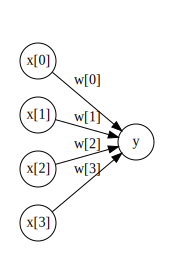

In [12]:
mglearn.plots.plot_logistic_regression_graph()

MLP에서는 가중치 합을 만드는 과정이 여러 번 반복되며, 먼저 중간 단계를 구성하는 **은닉 유닛** *hiddeen unit*을 계산하고 이를 이용해 최종 가중치 합을 계산한다. 이런 모델은 많은 계수(가중치)를 학습해야 하며 이 계수는 각 입력과 **은닉층**사이, 은닉층과 출력 사이마다 있다.

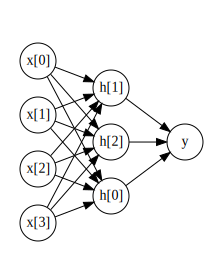

In [13]:
mglearn.plots.plot_single_hidden_layer_graph()

여러 개의 가중치 합을 계산하는 것은 수학적으로 하나의 가중치 합을 계산하는 것과 같다.(단순 선형 함수이기 때문) 선형 모델보다 강력하게 만들려면 각 은닉 유닛의 가중치 합을 계산한 후 그 결과의 비선형 함수인 **렐루** *rectified linear unit, ReLU*나 **하이퍼볼릭 탄젠트** *hyperbolic tangent, tanh*를 적용한다. 두 함수는 아래 그림과 같다. 이런 비선형 함수를 이용해 신경망이 선형 모델보다 더 복잡한 함수를 학습할 수 있다.

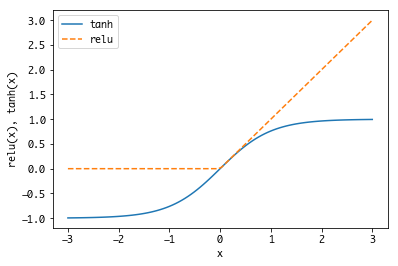

In [14]:
line = np.linspace(-3, 3, 100)
plt.plot(line, np.tanh(line), label="tanh")
plt.plot(line, np.maximum(line, 0), linestyle='--', label="relu")
plt.legend(loc="best")
plt.xlabel("x")
plt.ylabel("relu(x), tanh(x)")

위의 신경망으로 (tanh 함수를 비선형 함수로 사용해서) 회귀분석을 할 때 $\hat y$를 계산하는 전체 공식은 다음과 같다.
$$h[0]=\tanh(w[0,0] \times x[0]+w[1,0] \times x[1]+w[2,0] \times x[2]+w[3,0] \times x[3]+b[0])$$ 
$$h[1]=\tanh(w[0,1] \times x[0]+w[1,1] \times x[1]+w[2,1] \times x[2]+w[3,1] \times x[3]+b[1])$$
$$h[1]=\tanh(w[0,2] \times x[0]+w[1,2] \times x[1]+w[2,2] \times x[2]+w[3,2] \times x[3]+b[2])$$
$$\hat y=v[0] \times h[0]+v[1] \times h[1]+v[2] \times h[2]+b$$
w: 입력 x와 은닉층 h 사이의 가중치, v: 은닉층과 출력 사이의 가중치

보통 분류의 경우 신경망 마지막 출력층에 시그모이드(이진 분류)나 소프트맥스(다중 분류) 함수를 적용하여 최종출력 $\hat y$를 계산한다. 소프트맥스는 여러 유닛의 출력값을 정규화하기 위한 함수로 ${e^{z_j}\over{\sum_{i=1}^k}e^{z_i}}$와 같이 나타낸다. (z는 각 유닛의 출력값, k는 유닛 개수)

은닉층의 유닛 개수와 은닉층의 수를 정하는 것이 중요하다. 이렇게 많은 은닉층으로 구성된 대규모의 신경망이 생기면서 이를 딥러닝이라고 부르게 되었다.

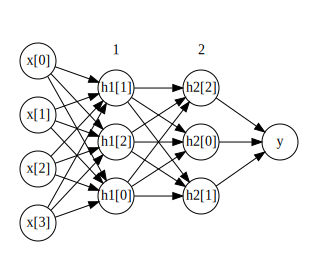

In [15]:
mglearn.plots.plot_two_hidden_layer_graph()

#### 신경망 튜닝
two_moon 데이터셋에 다층 퍼셉트론(MLP) 구현인 `MLPClassifier`를 적용해본다.

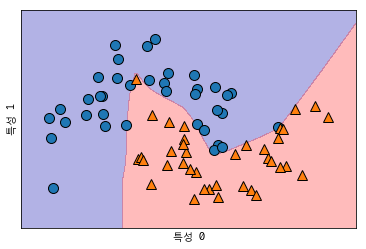

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=42)

mlp = MLPClassifier(solver='lbfgs', random_state=0).fit(X_train, y_train)

mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.xlabel("특성 0")
plt.ylabel("특성 1")

이 신경망은 매우 비선형적이지만 비교적 매끄러운 결정 경계를 만들었다. 사용된 최적화 알고리즘은 `lbfgs`이다. MLP는 기본적으로 은닉 유닛 100개를 사용하는데, 이런 작은 데이터셋에서는 개수를 줄여도 여전히 좋은 결과를 얻을 수 있다.(모델의 복잡도는 낮아진다.) 은닉 유닛이 10개인 경우 결정 경계가 더 날카로워졌다. 기본 비선형 함수는 ReLU이다. 더 매끄러운 결정 경계를 원한다면 은닉 유닛을 추가하거나, 은닉층을 추가하거나 비선형 함수를 tanh로 사용할 수 있다.

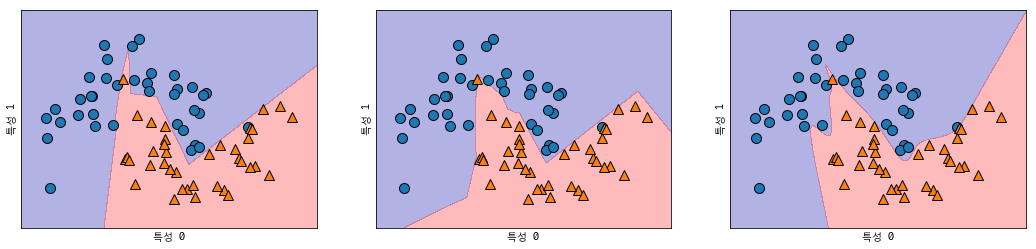

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

mlp = [MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[10]), # 은닉유닛 10개
       MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[10, 10]), # 은닉층 2개
       MLPClassifier(solver='lbfgs', activation='tanh', random_state=0, hidden_layer_sizes=[10, 10]) # tanh 활성화 함수
      ]

for n, ax in zip([0, 1, 2], axes):
    mlp[n].fit(X_train, y_train)
    mglearn.plots.plot_2d_separator(mlp[n], X_train, ax=ax, fill=True, alpha=.3)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, ax=ax)
    ax.set_xlabel("특성 0")
    ax.set_ylabel("특성 1")

릿지 회귀와 선형 분류기에서 한 것처럼 L2 패널티를 사용해서 가중치를 0에 가깝게 감소시켜 모델의 복잡도를 제어할 수 있다. `MLPClassifier`에서 이런 역할을 선형 회귀 모델에서와 같이 `alpha` 인자가 한다. 기본값은 매우 낮게 (거의 규제하지 않게) 되어 있다. 아래는 각각 은닉층 10개와 100개일 때 alpha 값이 미치는 영향을 보여준다.

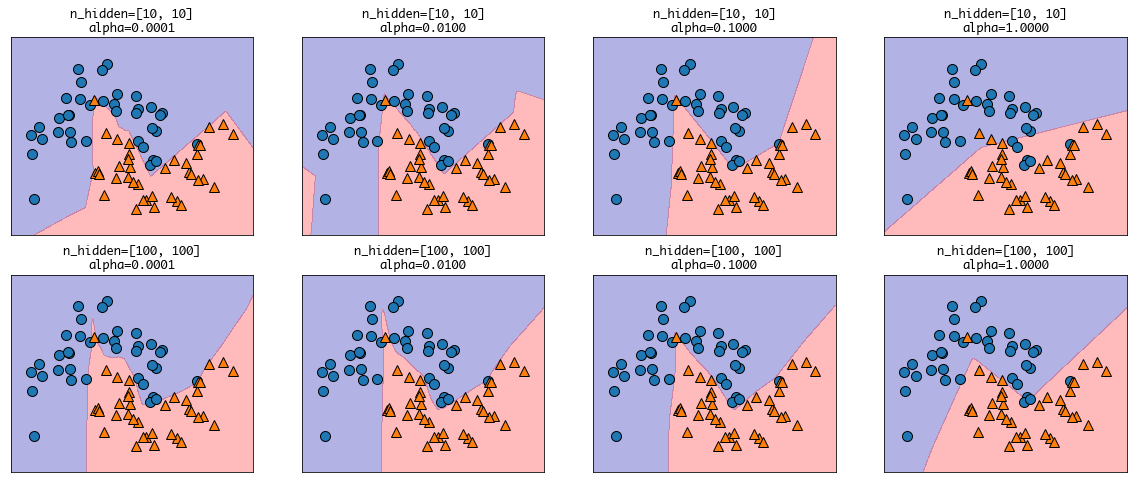

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for axx, n_hidden_nodes in zip(axes, [10, 100]):
    for ax, alpha in zip(axx, [0.0001, 0.01, 0.1, 1]):
        mlp = MLPClassifier(solver='lbfgs', random_state=0,
                            hidden_layer_sizes=[n_hidden_nodes, n_hidden_nodes],
                            alpha=alpha)
        mlp.fit(X_train, y_train)
        mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3, ax=ax)
        mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, ax=ax)
        ax.set_title("n_hidden=[{}, {}]\nalpha={:.4f}".format(
                      n_hidden_nodes, n_hidden_nodes, alpha))

신경망의 복잡도를 제어하는 방법에는 은닉층의 수, 은닉 유닛 개수, 규제(alpha), 드롭아웃 등이 있다.

신경망에서는 학습을 시작하기 전 가중치를 무작위로 설정하며 이 값이 학습에 영향을 준다. 같은 매개변수를 사용하더라도 초깃값이 다르면 모델이 달라질 수 있다.  
아래는 같은 매개변수지만 초기화를 다르게 한 모델들이다.

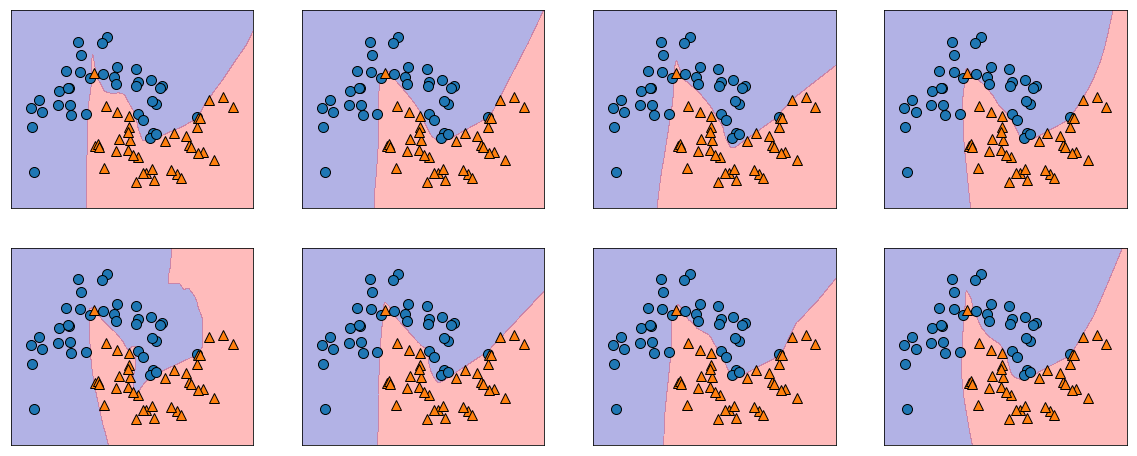

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for i, ax in enumerate(axes.ravel()):
    mlp = MLPClassifier(solver='lbfgs', random_state=i,
                        hidden_layer_sizes=[100, 100])
    mlp.fit(X_train, y_train)
    mglearn.plots.plot_2d_separator(mlp, X_train, fill=True, alpha=.3, ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, ax=ax)

유방암 데이터셋에 `MLPClassifier`를 적용한다. 매개변수는 기본값을 사용한다.

In [20]:
print("유방암 데이터의 특성별 최대값:\n{}".format(cancer.data.max(axis=0)))

유방암 데이터의 특성별 최대값:
[  2.81100000e+01   3.92800000e+01   1.88500000e+02   2.50100000e+03
   1.63400000e-01   3.45400000e-01   4.26800000e-01   2.01200000e-01
   3.04000000e-01   9.74400000e-02   2.87300000e+00   4.88500000e+00
   2.19800000e+01   5.42200000e+02   3.11300000e-02   1.35400000e-01
   3.96000000e-01   5.27900000e-02   7.89500000e-02   2.98400000e-02
   3.60400000e+01   4.95400000e+01   2.51200000e+02   4.25400000e+03
   2.22600000e-01   1.05800000e+00   1.25200000e+00   2.91000000e-01
   6.63800000e-01   2.07500000e-01]


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)

print("훈련 세트 정확도: {:.2f}".format(mlp.score(X_train, y_train)))
print("테스트 세트 정확도: {:.2f}".format(mlp.score(X_test, y_test)))

훈련 세트 정확도: 0.91
테스트 세트 정확도: 0.88


정확도를 높이기 위해서는 SVC 예제에서처럼 스케일을 맞추어야 한다. 모든 입력 특성을 평균 0, 분산 1이 되도록 정규화 시키는 것이 좋다.(이를 자동으로 처리해주는 `StandardScaler`가 있다.) 이를 위해서 데이터에서 평균을 빼고 표준편차로 나누어 z-score를 사용한다.

In [22]:
# 훈련 세트 각 특성의 평균을 계산합니다
mean_on_train = X_train.mean(axis=0)
# 훈련 세트 각 특성의 표준 편차를 계산합니다
std_on_train = X_train.std(axis=0)

# 데이터에서 평균을 빼고 표준 편차로 나누면
# 평균 0, 표준 편차 1 인 데이터로 변환됩니다.
X_train_scaled = (X_train - mean_on_train) / std_on_train
# (훈련 데이터의 평균과 표준 편차를 이용해) 같은 변환을 테스트 세트에도 합니다
X_test_scaled = (X_test - mean_on_train) / std_on_train

mlp = MLPClassifier(random_state=0)
mlp.fit(X_train_scaled, y_train)

print("훈련 세트 정확도: {:.3f}".format(mlp.score(X_train_scaled, y_train)))
print("테스트 세트 정확도: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

훈련 세트 정확도: 0.991
테스트 세트 정확도: 0.965


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


정확도가 높아졌다. 최대 반복 횟수에 도달했다는 경고는 모델을 학습시키는 `adam` 알고리즘에 관한 것으로 반복 횟수를 늘려줘야 한다.

In [23]:
mlp = MLPClassifier(max_iter=1000, random_state=0)
mlp.fit(X_train_scaled, y_train)

print("훈련 세트 정확도: {:.3f}".format(mlp.score(X_train_scaled, y_train)))
print("테스트 세트 정확도: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

훈련 세트 정확도: 0.993
테스트 세트 정확도: 0.972


알파 매개변수를 0.0001에서 1로 크게 증가시켜 모델의 복잡도를 낮추어보자. 훈련 데이터와 테스트 데이터의 차이가 줄어든다.

In [24]:
mlp = MLPClassifier(max_iter=1000, alpha=1, random_state=0)
mlp.fit(X_train_scaled, y_train)

print("훈련 세트 정확도: {:.3f}".format(mlp.score(X_train_scaled, y_train)))
print("테스트 세트 정확도: {:.3f}".format(mlp.score(X_test_scaled, y_test)))

훈련 세트 정확도: 0.988
테스트 세트 정확도: 0.972


이는 지금까지 가장 좋은 모델의 성능과 동일하다.(모두 4개의 외딴 포인트에서 실수한다.)

신경망의 분석은 선형 모델이나 트리 모델보다 까다롭다. 모델의 가중치 값을 통해 어떤 특성이 학습되었는지 확인할 수 있다. 모든 은닉 유닛에서 작은 가중치를 가진 특성은 모델에 덜 중요하다고 추론할 수 있다.

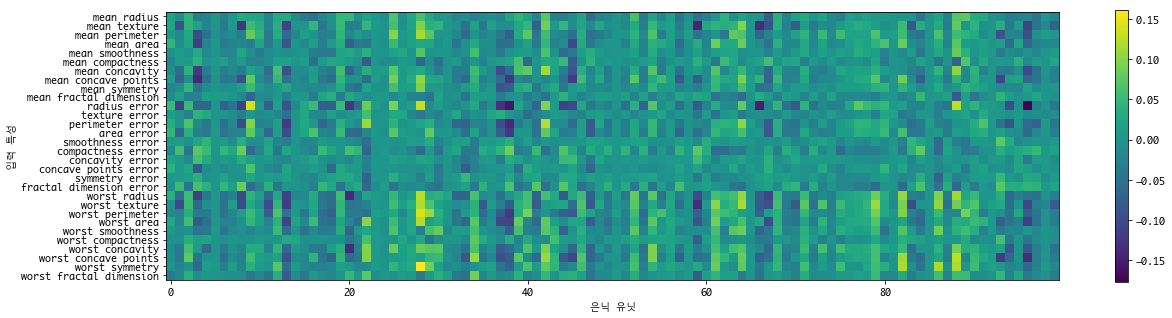

In [25]:
plt.figure(figsize=(20, 5))
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(30), cancer.feature_names)
plt.xlabel("은닉 유닛")
plt.ylabel("입력 특성")
plt.colorbar()

scikit-learn에서 제공하는 `MLPClassifier`와 `MLPRegressor`는 최근 유행하는 합성곱 신경망(CNN, convolutional neural network)이나 순환 신경망(RNN, recurrent neural network)을 제공하지 않는다. 더 복잡하고 대규모 모델을 만들기 위해선 전문 딥러닝 라이브러리를 사용해야 한다.  
파이썬에서는 keras, tensorflow, PyTorch 등이 널리 사용된다. 추가로 이런 라이브러리에서는 GPU 가속을 지원한다.

#### 장단점과 매개변수
* 장점: 대량의 데이터에 내재된 정보를 잡아내어 매우 복잡한 모델을 만들 수 있다. 충분한 시간과 데이터를 주고 매개변수를 조정하면 다른 알고리즘을 능가하는 성능을 낸다.
* 단점: 크고 강력한 모델에서는 학습이 오래 걸리며 데이터 전처리가 필요하다. 매개변수 튜닝이 어렵다.

#### 신경망의 복잡도 추정
신경망의 가장 중요한 매개변수는 은닉층의 개수와 유닛 수이다. 처음엔 1~2개 층에서 시작해서 늘려가야 한다. 은닉유닛 수는 보통 입력 특성의 수와 비슷하게 설정하지만 수천 초중반을 넘는 일은 거의 없다.

신경망의 매개변수를 조정하는 일반적인 방법은 충분히 과적합될만한 큰 모델은 만든 뒤 신경망 구조를 줄이거나 규제를 강화해 일반화 성능을 향상시키는 것이다.

* `solver` 매개변수: 기본값은 adam으로 대부분 잘 작동하지만 데이터 스케일에 조금 민감하다. `lbfgs`는 안정적이지만 규모가 큰 모델이나 대량이 데이터셋에는 시간이 오래 걸린다. `sgd`는 다른 여러 매개변수와 함께 튜닝하여 최선의 결과를 만들 수 있다.

BFGS : 연구자 Broyden-Fletcher-Goldfarb-Shanno의 이름을 딴 의사 뉴턴 메서드 중 하나. L-BFGS(Limited-memory BFGS)는 이 알고리즘을 제한된 메모리에서 구현한 방법이다.

## 2.4 분류 예측의 불확실성 추정
테스트 포인트에 대해 분류기가 예측한 클래스가 무엇인지 뿐만 아니라 정확한 클래스임을 얼마나 확신하는지가 중요할 때가 많다. 거짓 양성, 거짓 음성은 문제가 될 수 있다. scikit-learn의 대부분의 분류 클래스는 예측의 불확실성을 추정할 수 있는 함수 `decision_function`, `predict_proba`를 제공한다.

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_circles
X, y = make_circles(noise=0.25, factor=0.5, random_state=1)

# 예제를 위해 클래스의 이름을 "blue" 와 "red" 로 바꿉니다
y_named = np.array(["blue", "red"])[y]

# 여러개의 배열을 한꺼번에 train_test_split 에 넣을 수 있습니다
# 훈련 세트와 테스트 세트로 나뉘는 방식은 모두 같습니다.
X_train, X_test, y_train_named, y_test_named, y_train, y_test = \
    train_test_split(X, y_named, y, random_state=0)

# 그래디언트 부스팅 모델을 만듭니다
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

### 결정 함수
이진 분류에서 decision_function의 return값의 크기는 (n_samples,)이며 각 샘플이 하나의 실수 값을 반환한다.

In [29]:
print("X_test.shape: {}".format(X_test.shape))
print("결정 함수 결과 형태: {}".format(gbrt.decision_function(X_test).shape))

# 결정 함수 결과 중 앞부분 일부를 확인합니다
print("결정 함수:\n{}".format(gbrt.decision_function(X_test)[:6]))

X_test.shape: (25, 2)
결정 함수 결과 형태: (25,)
결정 함수:
[ 4.13592629 -1.7016989  -3.95106099 -3.62599351  4.28986668  3.66166106]


양수 값은 모델이 클래스1에 속한다고 믿는 정도이며 음수 값은 다른 클래스이다. 부호만 보고 예측 결과를 알 수 있다.

In [31]:
print("임계치와 결정 함수 결과 비교:\n{}".format(
      gbrt.decision_function(X_test) > 0))
print("예측:\n{}".format(gbrt.predict(X_test)))

임계치와 결정 함수 결과 비교:
[ True False False False  True  True False  True  True  True False  True
  True False  True False False False  True  True  True  True  True False
 False]
예측:
['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']


In [32]:
# 불리언 값을 0과 1로 변환합니다
greater_zero = (gbrt.decision_function(X_test) > 0).astype(int)
# classes_에 인덱스로 사용합니다
pred = gbrt.classes_[greater_zero]
# pred 와 gbrt.predict의 결과를 비교합니다
print("pred 는 예측 결과와 같다: {}".format(
      np.all(pred == gbrt.predict(X_test))))

pred 는 예측 결과와 같다: True


결정 함수 값의 범위는 데이터와 모델 파라미터에 따라 달라진다.

In [33]:
decision_function = gbrt.decision_function(X_test)
print("결정 함수 최소값: {:.2f} 최대값: {:.2f}".format(
      np.min(decision_function), np.max(decision_function)))

결정 함수 최소값: -7.69 최대값: 4.29


평면의 모든 점에 대해 decision_function 값을 색으로 표현하여 결정 경계와 함께 그래프로 나타낸다.

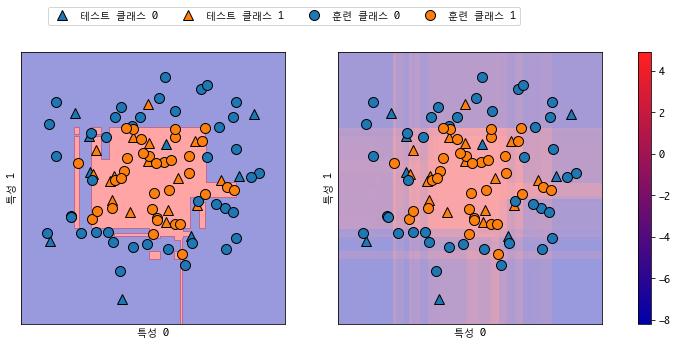

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    
mglearn.tools.plot_2d_separator(gbrt, X, ax=axes[0], alpha=.4,
                                fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(gbrt, X, ax=axes[1],
                                            alpha=.4, cm=mglearn.ReBl)

for ax in axes:
    # 훈련 포인트와 테스트 포인트를 그리기
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                             markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                             markers='o', ax=ax)
    ax.set_xlabel("특성 0")
    ax.set_ylabel("특성 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["테스트 클래스 0", "테스트 클래스 1", "훈련 클래스 0",
                "훈련 클래스 1"], ncol=4, loc=(.1, 1.1))

### 예측 확률
predict_proba의 출력은 각 클래스에 대한 확률이고 decision_function의 출력보다 이해하기 더 쉽니다. 이 값의 크기는 이진 분류에서는 `(n_samples, 2)`이다. 값의 합은 항상 1이다.

In [35]:
print("확률 값의 형태: {}".format(gbrt.predict_proba(X_test).shape))

# predict_proba 결과 중 앞부분 일부를 확인합니다
print("Predicted probabilities:\n{}".format(
      gbrt.predict_proba(X_test[:6])))

확률 값의 형태: (25, 2)
Predicted probabilities:
[[ 0.01573626  0.98426374]
 [ 0.84575649  0.15424351]
 [ 0.98112869  0.01887131]
 [ 0.97406775  0.02593225]
 [ 0.01352142  0.98647858]
 [ 0.02504637  0.97495363]]


대부분 포인트에서 비교적 강하게 확신하고 있는데, 불확실성이 얼마나 잘 반영되는지는 모델과 매개변수 설정에 달렸다. 과적합된 모델은 잘못된 예측이라도 예측의 확신이 강하며, 복잡도가 낮은 모델일수록 예측에 불확실성이 더 많다. 불확실성과 모델의 정확도가 동등하면 이 모델이 **보정** *calibration*되었다고 한다. 보정된 모델에서 70% 확신을 가진 예측은 70%의 정확도를 낸다.

같은 데이터셋을 사용해 결정 경계와 확률을 그래프로 나타낸다.

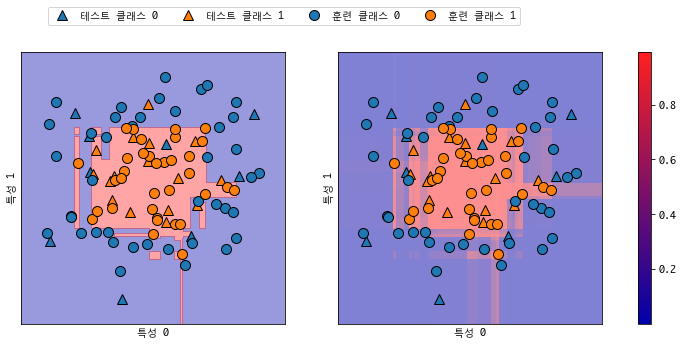

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    
mglearn.tools.plot_2d_separator(
    gbrt, X, ax=axes[0], alpha=.4, fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(
    gbrt, X, ax=axes[1], alpha=.5, cm=mglearn.ReBl, function='predict_proba')

for ax in axes:
    # 훈련 포인트와 테스트 포인트를 그리기
    mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test,
                             markers='^', ax=ax)
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train,
                             markers='o', ax=ax)
    ax.set_xlabel("특성 0")
    ax.set_ylabel("특성 1")
# colorbar 를 감추지 않습니다.
cbar = plt.colorbar(scores_image, ax=axes.tolist())
cbar.set_alpha(1)
cbar.draw_all()
axes[0].legend(["테스트 클래스 0", "테스트 클래스 1", "훈련 클래스 0",
                "훈련 클래스 1"], ncol=4, loc=(.1, 1.1))

### 다중 분류에서의 불확실성
`decision_gunction`과 `predict_proba` 메서드는 다중 분류에도 사용할 수 있다. 클래스가 3개인 iris 데이터셋에 적용해본다.

In [37]:
from sklearn.datasets import load_iris

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=42)

gbrt = GradientBoostingClassifier(learning_rate=0.01, random_state=0)
gbrt.fit(X_train, y_train)

print("결정 함수의 결과 형태: {}".format(gbrt.decision_function(X_test).shape))
# plot the first few entries of the decision function
print("결정 함수 결과:\n{}".format(gbrt.decision_function(X_test)[:6, :]))

결정 함수의 결과 형태: (38, 3)
결정 함수 결과:
[[-0.52931069  1.46560359 -0.50448467]
 [ 1.51154215 -0.49561142 -0.50310736]
 [-0.52379401 -0.4676268   1.51953786]
 [-0.52931069  1.46560359 -0.50448467]
 [-0.53107259  1.28190451  0.21510024]
 [ 1.51154215 -0.49561142 -0.50310736]]


결과값의 크기는 `(n_samples, n_classes)`이다. 각 열은 각 클래스에 대한 확신 점수를 담고 있다. 데이터 포인트마다 점수들에서 가장 큰 값을 찾아 예측 결과를 재현할 수 있다.

In [38]:
print("가장 큰 결정 함수의 인덱스:\n{}".format(
      np.argmax(gbrt.decision_function(X_test), axis=1)))
print("예측:\n{}".format(gbrt.predict(X_test)))

가장 큰 결정 함수의 인덱스:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
예측:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


predict_proba의 출력값 크기는 `(n_samples, n_classes)`이며, 각 데이터에서 클래스 확률의 합은 1이다.

In [39]:
# predict_proba 결과 중 앞부분 일부를 확인합니다
print("예측 확률:\n{}".format(gbrt.predict_proba(X_test)[:6]))
# 행 방향으로 확률을 더하면 1 이 됩니다
print("합: {}".format(gbrt.predict_proba(X_test)[:6].sum(axis=1)))

print("가장 큰 예측 확률의 인덱스:\n{}".format(
      np.argmax(gbrt.predict_proba(X_test), axis=1)))
print("예측:\n{}".format(gbrt.predict(X_test)))

예측 확률:
[[ 0.10664722  0.7840248   0.10932798]
 [ 0.78880668  0.10599243  0.10520089]
 [ 0.10231173  0.10822274  0.78946553]
 [ 0.10664722  0.7840248   0.10932798]
 [ 0.10825347  0.66344934  0.22829719]
 [ 0.78880668  0.10599243  0.10520089]]
합: [ 1.  1.  1.  1.  1.  1.]
가장 큰 예측 확률의 인덱스:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
예측:
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


클래스가 문자열이거나 정수형이지만 연속되지 않거나 0부터 시작하지 않을 수 있으므로, predict의 결과와 예측 함수의 결과를 비교하려면 분류기의 `classes_` 속성을 사용해 클래스의 실제 이름을 얻는 것이 확실하다.

In [41]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

# iris 데이터셋의 타깃을 클래스 이름으로 나타내기
named_target = iris.target_names[y_train]
logreg.fit(X_train, named_target)
print("훈련 데이터에 있는 클래스 종류: {}".format(logreg.classes_))
print("예측: {}".format(logreg.predict(X_test)[:10]))
argmax_dec_func = np.argmax(logreg.decision_function(X_test), axis=1)
print("가장 큰 결정 함수의 인덱스: {}".format(argmax_dec_func[:10]))
print("인덱스를 classses_에 연결: {}".format(
      logreg.classes_[argmax_dec_func][:10]))

훈련 데이터에 있는 클래스 종류: ['setosa' 'versicolor' 'virginica']
예측: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']
가장 큰 결정 함수의 인덱스: [1 0 2 1 1 0 1 2 1 1]
인덱스를 classses_에 연결: ['versicolor' 'setosa' 'virginica' 'versicolor' 'versicolor' 'setosa'
 'versicolor' 'virginica' 'versicolor' 'versicolor']


## 2.5 요약 및 정리
* **최근접 이웃**  
작은 데이터셋일 경우, 기본 모델로서 좋고 설명하기 쉬움.
* **선형 모델**  
첫 번째로 시도할 알고리즘, 대용량 데이터셋 가능. 고차원 데이터에 가능.
* **나이브 베이즈**  
분류만 가능. 선형 모델보다 훨씬 빠름. 대용량 고차원 데이터에 가능. 선형 모델보다 덜 정확함
* **결정 트리**  
매우 빠름. 데이터 스케일 조정 필요 없음. 시각화하기 좋고 설명이 쉬움
* **랜덤 포레스트**  
결정 트리 하나보다 거의 항상 좋은 성능을 냄. 매우 안정적이고 강력함. 스케일 조정 필요 없음. 고차원 희소 데이터에는 잘 안맞음.
* **그래디언트 부스팅 결정 트리**  
램덤 포레스트보다 조금 더 성능이 좋음. 랜덤 포레스트보다 학습은 느리나 예측은 빠르고 메모리를 조금 사용. 랜덤 포레스트보다 매개변수 튜닝이 많이 필요함
* **서포트 벡터 머신**  
비슷한 의미의 특성으로 이뤄진 중간 규모 데이터셋에 잘 맞음. 데이터 스케일 조정 필요. 매개변수에 민감.
* **신경망**  
특별히 대용량 데이터셋에서 매우 복잡한 모델을 만들 수 있음. 매개변수 선택과 데이터 스케일에 민감. 큰 모델은 학습이 오래 걸림.

새로운 데이터셋으로 작업할 때는 선형 모델, 나이브 베이즈, 최근접 이웃 같은 간단한 모델로 시작해 성능을 가늠한 뒤 데이터를 충분히 이해하고 랜덤 포레스트, 그래디언트 부스팅, SVM, 신경망 같은 복잡한 모델을 고려해보는 것이 좋다.